In [1]:
# Allow reload of objects
%load_ext autoreload
%autoreload
from pelenet.utils import Utils
from pelenet.experiments.readout import ReadoutExperiment
from pelenet.network import ReservoirNetwork

# Official modules
import numpy as np
import nxsdk.api.n2a as nx
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from time import time

In [2]:
# Initilizes the experiment and utils
utils = Utils.instance()
exp = ReadoutExperiment()

In [3]:
np.load('data/nest/input.npy')[0,0]

array([ 61,  62,  63,  64,  65, 121, 122, 123, 124, 125, 181, 182, 183,
       184, 185, 241, 243, 244, 245, 301, 302, 303, 304, 305])

In [4]:
from scipy.sparse import csr_matrix

# Build network
exp.net = ReservoirNetwork(exp.p)

exp.net.initialMasks.exex = csr_matrix(np.load('data/nest/weights_ee.npy'))
exp.net.initialMasks.exin = csr_matrix(np.load('data/nest/weights_ei.npy'))
exp.net.initialMasks.inex = csr_matrix(np.load('data/nest/weights_ii.npy'))
exp.net.initialMasks.inin = csr_matrix(np.load('data/nest/weights_ie.npy'))

# Set weights
exp.setSparseWeightMatrix()

# Connect
exp.net.connectReservoir()

# Add patch input
exp.net.addRepeatedPatchGenerator(idc = np.load('data/nest/input.npy')[0,0])

# Build the network structure
exp.net.build()

In [5]:
# Get spectral radius
utils.getSpectralRadius(exp.net.initialWeights)

1.761

In [6]:
exp.run()

INFO:DRV:  Connecting to 127.0.0.1:45845
INFO:DRV:      Host server up..............Done 0.06s
INFO:DRV:      Encoding axons/synapses.....Done 15.01s
Compiling in directory : /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1583934328.5104198
Include dir is : /home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/
Compiling -c /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1583934328.5104198/initnetwork_0_0.c
gcc -Wall -I/home/seq/05-reward/v0.x/pelenet/snips/ -I/home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/graph/nxinputgen/../../snips/ -Inxsdk/include -fno-stack-protector -msoft-float -m32 -march=i586 -fno-builtin-printf -fno-builtin-sprintf -fno-builtin-fprintf -fno-builtin-memcpy -fstrict-volatile-bitfields -Os -DNDEBUG -st

INFO:DRV:      Compiling Embedded snips....Done 0.61s
INFO:DRV:      Encoding probes.............Done 3.99ms
INFO:HST:  Using Kapoho Bay serial number 308
INFO:HST:  Args chip=0 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1583934328.5104198/launcher_chip0_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Args chip=1 cpu=0 /home/seq/.local/share/virtualenvs/seq-r0_WvjRo/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1583934328.5104198/launcher_chip1_lmt0.bin --chips=2 --remote-relay=0 --epoch=0 
INFO:HST:  Lakemont_driver...
INFO:DRV:      Booting up..................Done 1.54s
INFO:DRV:      Transferring probes.........Done 0.04s
INFO:DRV:      Configuring registers.......Done 14.88s
INFO:DRV:      Transferring spikes.........Done 3.38ms
INFO:HST:  chip=1 cpu=0 Transfered values 20, 535, 30 
INFO:HST:  chip=0 cpu=0 Transfered values 20, 535, 30 
INFO:HST:  chip=1 cpu=0 Reset current/vol

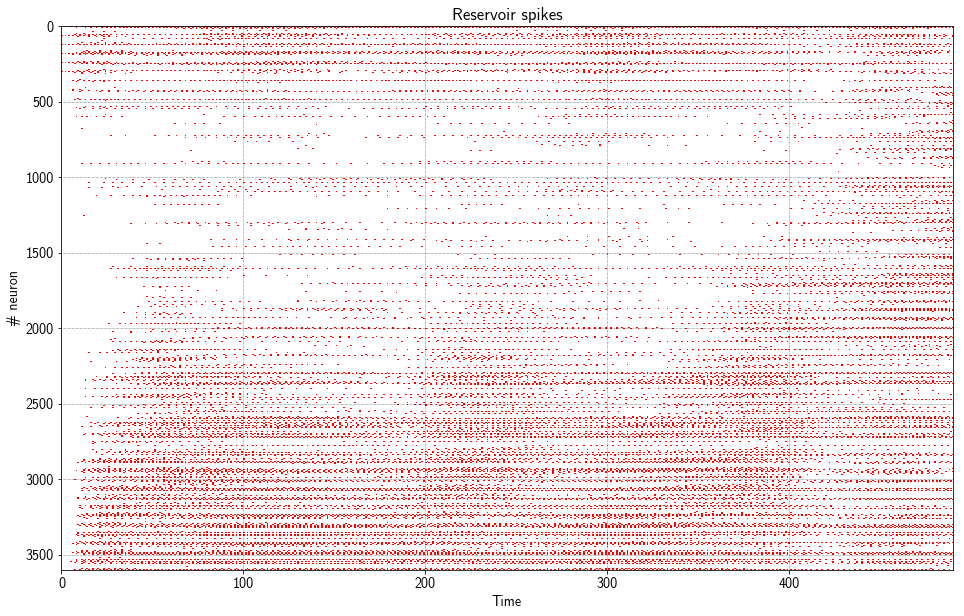

In [7]:
exp.net.plot.reservoirSpikeTrain(fr=exp.p.resetOffset, to=491+exp.p.resetOffset)

In [8]:
nest = np.array([np.load('data/nest/times.npy'), np.load('data/nest/inds.npy')])

spikes = []

mi, ma = int(np.floor(np.min(nest[0]))), int(np.ceil(np.max(nest[0])))
for t in range(mi, ma):
    idcs = []
    for i in np.arange(0.0,1.0,0.1):
        idcs.extend(np.where(np.isclose(nest[0], t+i))[0])
    spkVec = np.zeros((exp.p.reservoirExSize))
    spkVec[nest[1, idcs].astype(int)-1] = 1
    spikes.append(spkVec)
spikes = np.array(spikes).T

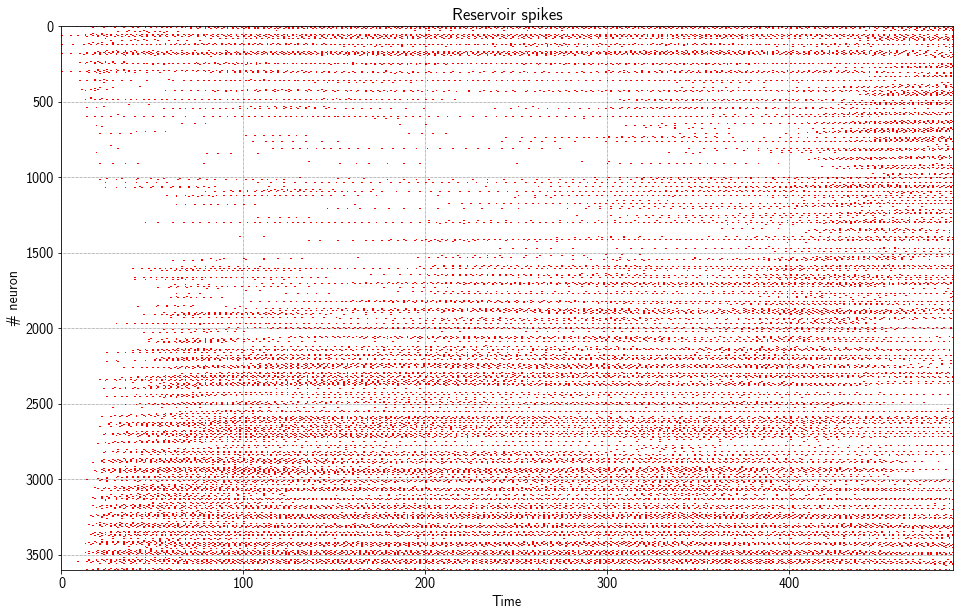

In [9]:
plt.figure(figsize=(16, 10))
cmap = colors.ListedColormap(['white', 'red'])
plt.title('Reservoir spikes')
plt.xlabel('Time')
plt.ylabel('# neuron')
p = plt.imshow(spikes, cmap=cmap, aspect='auto')

In [10]:
sl = exp.net.exSpikeTrains[:,exp.p.resetOffset:491+exp.p.resetOffset]  # spikes from loihi
sn = spikes # spikes from nest

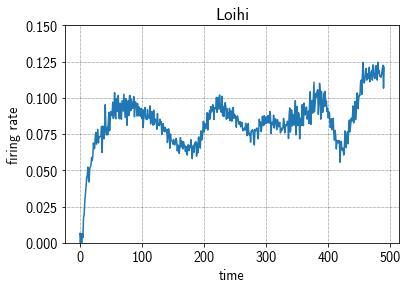

In [11]:
plt.plot(np.mean(sl, axis=0))
plt.title('Loihi')
plt.xlabel('time')
plt.ylabel('firing rate')
plt.ylim((0,0.15))
p = plt.show()

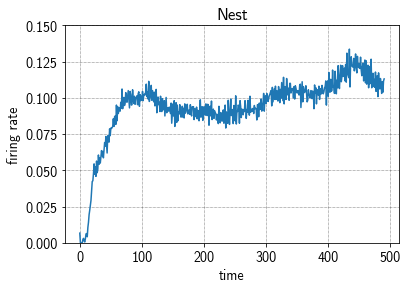

In [12]:
plt.plot(np.mean(sn, axis=0))
plt.title('Nest')
plt.xlabel('time')
plt.ylabel('firing rate')
plt.ylim((0,0.15))
p = plt.show()

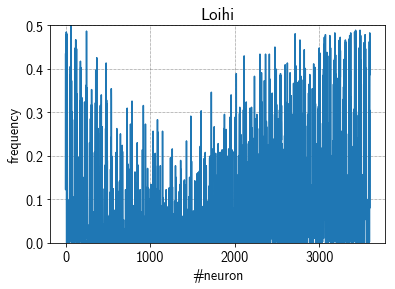

In [13]:
plt.plot(np.mean(sl, axis=1))
plt.title('Loihi')
plt.xlabel('#neuron')
plt.ylabel('frequency')
plt.ylim((0,0.5))
p = plt.show()

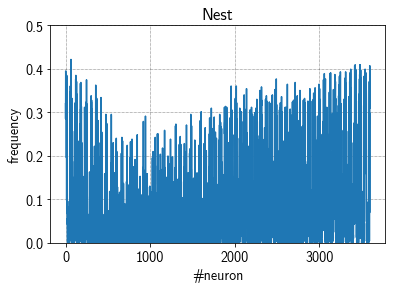

In [14]:
plt.plot(np.mean(sn, axis=1))
plt.title('Nest')
plt.xlabel('#neuron')
plt.ylabel('frequency')
plt.ylim((0,0.5))
p = plt.show()

In [49]:
binl = np.array([np.mean(sl[:,i:i+10], axis=1) for i in range(0,490,10)])
binn = np.array([np.mean(sn[:,i:i+10], axis=1) for i in range(0,490,10)])

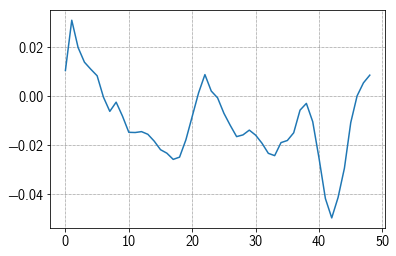

In [58]:
p = plt.plot(np.mean(binl-binn, axis=1))

In [115]:
topl = np.array([binl[:,i:i+60] for i in range(0,3600,60)])
topl = np.moveaxis(topl,1,0)

topn = np.array([binn[:,i:i+60] for i in range(0,3600,60)])
topn = np.moveaxis(topn,1,0)

In [110]:
topl[topl>0.2] = 1
topl[topl<=0.2] = 0

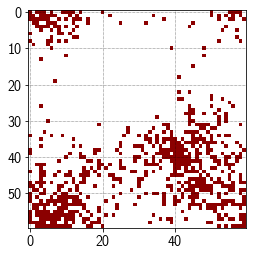

In [111]:
cmap = colors.ListedColormap(['white', 'darkred'])
p = plt.imshow(topl[5], cmap=cmap)

In [112]:
topn[topn>0.2] = 1
topn[topn<=0.2] = 0

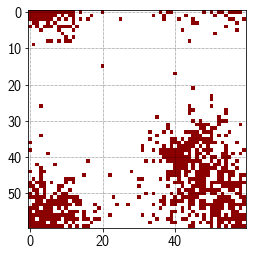

In [113]:
cmap = colors.ListedColormap(['white', 'darkred'])
p = plt.imshow(topn[5], cmap=cmap)

<IPython.core.display.Javascript object>


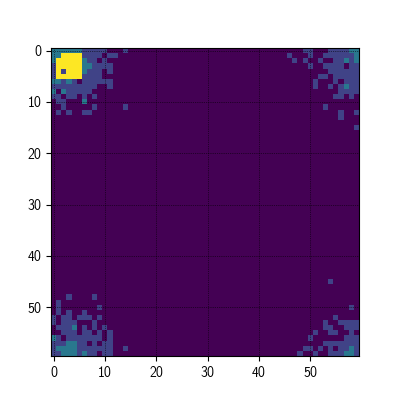

In [119]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(4,4))

#cmap = colors.ListedColormap(['white', 'darkred'])

frames = []
for i in range(topl.shape[0]):
    frames.append([plt.imshow(topl[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani.save('loihi.mp4')
plt.show()

<IPython.core.display.Javascript object>


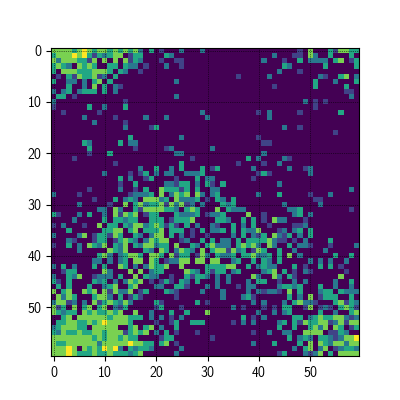

In [118]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(4,4))

#cmap = colors.ListedColormap(['white', 'darkred'])

frames = []
for i in range(topn.shape[0]):
    frames.append([plt.imshow(topn[i], animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1000)
ani.save('nest.mp4')
plt.show()